# Natural images CT Inverse problems with Gaussian Noise


In [76]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.transforms as transforms
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.models import DnCNN
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder

torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


In [ ]:
path = "data/butterfly.png"
image = Image.open(path)
image = image.convert('L')
transform = transforms.Compose([transforms.ToTensor(),])
img = transform(image)
img.reshape(1, 1, 2048, 1536)

C:\Users\as5057\AppData\Local\Temp\ipykernel_22156\3299097564.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x1, device=device, dtype=torch.float)


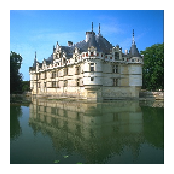

In [77]:
url = get_image_url("CBSD_0010.png")
x1 = load_url_image(url, grayscale = False).to(device)
x = torch.tensor(x1, device=device, dtype=torch.float)
x = torch.nn.functional.interpolate(x, size=(128, 128))
img_size = x.shape[1:]

plot(x)

# Radon Transform with Gaussian noise


In [78]:
noise_level = 0.1
radon = dinv.physics.Tomography(
    img_width = img_size[-1],
    angles = 100,
    device = device,
    noise_model = dinv.physics.GaussianNoise(sigma = 1)
)

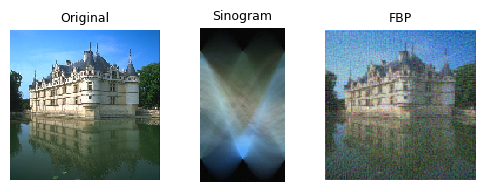

In [79]:
y = radon(x)
fbp = radon.A_dagger(y)
plot([x, y, fbp], titles = ["Original", "Sinogram", "FBP"])

In [74]:
img = x.permute(1, 2, 0).numpy()
plt.imshow(img)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [80]:
params1 = {"stepsize": 0.01, "lambda": 1e-1, "g_param": noise_level}
params2 = {"stepsize": 0.01, "lambda": 1, "g_param": noise_level}
params3 = {"stepsize": 0.01, "lambda": 1e+1, "g_param": noise_level}
params4 = {"stepsize": 0.01, "lambda": 1e+2, "g_param": noise_level}
max_iter = 100
channels = 3
L2 = L2()

dncnn = DnCNN(
    in_channels = channels,
    out_channels = channels,
    pretrained = "download",  
    device = "cpu",
)

In [96]:
prior = PnP(denoiser = dncnn)

model1 = optim_builder(
    iteration="PGD",
    prior= prior,
    data_fidelity = L2,
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params1,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

model2 = optim_builder(
    iteration="PGD",
    prior= prior,
    data_fidelity = L2,
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params2,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


model3 = optim_builder(
    iteration="PGD",
    prior= prior,
    data_fidelity = L2,
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params3,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


model4 = optim_builder(
    iteration="PGD",
    prior= prior,
    data_fidelity = L2,
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params4,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

model1.eval()
model1.eval()
model3.eval()
model4.eval()

def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, marker = 'o', markersize = 1)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    #ax1.legend()
    ax1.grid()

    ax2.semilogy(residuals, marker = 'o', markersize = 1.2)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    #ax1.legend()
    ax2.grid()


In [ ]:
del model1
del model2
del model3
del model4

NameError: name 'model1' is not defined

In [102]:
x_model1, metrics1 = model(y, radon, x_gt = x, compute_metrics = True)
#x_model2, metrics2 = model2(y, radon, x_gt = x, compute_metrics = True)
#x_model3, metrics3 = model3(y, radon, x_gt = x, compute_metrics = True)
#\x_model4, metrics4 = model4(y, radon, x_gt = x, compute_metrics = True)

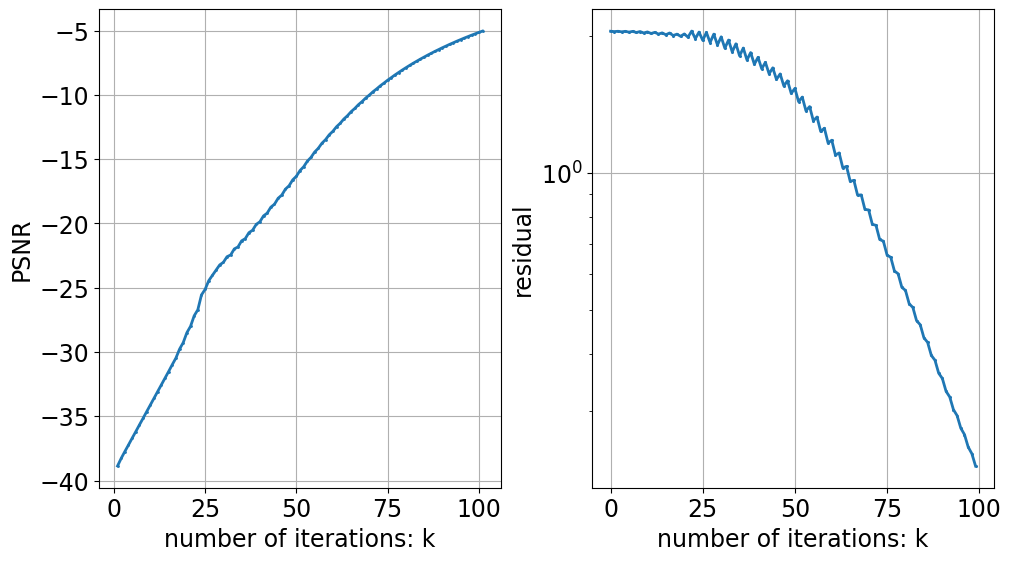

In [98]:
plot_psnrs_residuals(metrics1, 'DnCNN')

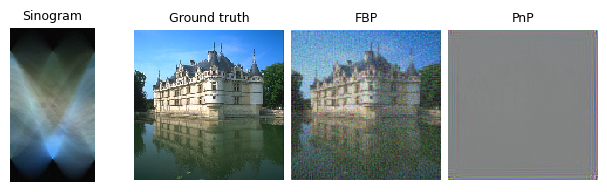

In [99]:
imgs = [y, x, fbp, x_model1]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP"])